# 1D EM Inversion
## Analytic Forward
### Middle resistive layer

In [1]:
import numpy as np
import empymod
import matplotlib.pyplot as plt
from scipy.constants import mu_0
import pygimli as pg

In [2]:
# Receivers geometry

offsets = np.array([2, 4, 8]) # in meters
height = -0.10 # meter height from ground surface to center of coil
rad = 0.08 # Define radius of coil

# For HCP
Hsource = [-rad, rad, -rad, rad, height, height]
Hreceivers = [offsets-rad, offsets+rad, np.ones(3)*-rad, np.ones(3)*rad, height, height]

# For VCP
Vsource = [0, 0, height, 90, 0]
Vreceivers = [offsets, offsets*0, height, 90, 0]

# For PRP
Psource = [0, 0, height]
Preceivers = [offsets+0.1, offsets*0, height]

# Frequency
freq = 9000

In [3]:
def Analytic_Forward(sigma1, sigma2, sigma3, thick1, thick2, height=height):
    # Returns apparent conductivity for each coil geometry and separation
    
    sigma1 = sigma1/1000
    sigma2 = sigma2/1000
    sigma3 = sigma3/1000
    
    surface = 0
    depth = [surface, thick1, thick1 + thick2]
    res_air = 2e14
    res = [res_air, 1/sigma1, 1/sigma2, 1/sigma3]
    HCP_Hs = empymod.loop(Hsource, Hreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    VCP_Hs = empymod.loop(Vsource, Vreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    PRP_Hs = empymod.dipole(Psource, Preceivers, depth, res, freq, ab = 64, xdirect = None, verb = 0)

    HCP_Hp = empymod.loop(Hsource, Hreceivers, depth=[], res=[res_air], freqtime=freq, mrec = 'loop', verb=0)
    VCP_Hp = empymod.loop(Vsource, Vreceivers, depth=[], res=[res_air], freqtime=freq, mrec = 'loop', verb=0)
    PRP_Hp = empymod.dipole(Psource, Preceivers, depth=[], res=[res_air], freqtime = freq, ab = 66, verb = 0)

    Q_HCP = -(np.imag(HCP_Hs/HCP_Hp))
    Q_VCP = (np.imag(VCP_Hs/VCP_Hp))
    Q_PRP = (np.imag(PRP_Hs/PRP_Hp))

    P_HCP = -(np.real(HCP_Hs/HCP_Hp))
    P_VCP = (np.real(VCP_Hs/VCP_Hp))
    P_PRP = (np.real(PRP_Hs/PRP_Hp))
    
    return np.hstack((Q_HCP, Q_VCP, Q_PRP, P_HCP, P_VCP, P_PRP))

In [4]:
sigma1, sigma2, sigma3 = 10, 50, 10
thick1, thick2 = 2, 2

Analytic_Forward(sigma1, sigma2, sigma3, thick1, thick2)

array([1.21929143e-03, 5.40544190e-03, 1.75851040e-02, 9.25515771e-04,
       4.48127736e-03, 1.89188839e-02, 9.41243616e-04, 4.96579818e-03,
       2.29058781e-02, 5.39001618e-05, 4.02443856e-04, 2.78912278e-03,
       2.74078669e-05, 2.09054767e-04, 1.54604383e-03, 6.61920244e-06,
       8.12614401e-05, 8.76345539e-04])

In [5]:
# parameters for the synthetic model

nlayer = 3 # number of layer
npos = 20 # number of sampling positions

sig_ini = [10, 50, 10]
sigmas = np.ones((npos, nlayer))*sig_ini
x = np.linspace(0, 20, npos)[:,None]
thk1 = 2 + 0.2 * np.sin(x*np.pi*2) # wave
thk2 = 2 + np.sin(x*np.pi*2) # wave
depthmax = 10
ny = 50

In [6]:
# Arrays for plotting
y = np.linspace(0, depthmax, ny)
xx = np.linspace(0,npos+1,npos+1, endpoint=False) # For step plot

def PlotModel(thk1, thk2, sigmas, npos, ny, Model, vmin=5, vmax=60):
    surface = np.zeros(npos)
    depth = np.zeros((npos,4))

    # Depths to be plotted
    for i in range(npos):
        depth[i,0] = 0
        depth[i,1] = thk1[i]
        depth[i,2] = thk1[i] + thk2[i]
        depth[i,3] = thk1[i] + thk2[i]
        
    sigy = np.zeros((npos, ny))

    # Conductivities array to be plotted
    for i in range(npos):
        y1=0
        while y[y1] <= depth[i, 1]:
            sigy[i, y1] = sigmas[i, 0]
            y1 += 1
            y2=y1
        while y[y2] <= depth[i, 2]:
            sigy[i, y2] = sigmas[i, 1]
            y2 += 1
            if y2 == 50:
                break
        sigy[i, y2:] = sigmas[i, 2]
        
    fig, ax = plt.subplots()
    pos = ax.imshow(sigy.T, cmap='viridis', interpolation='none', extent=[0,npos,10,0], vmin =vmin, vmax=vmax)
    clb = fig.colorbar(pos, shrink=0.5)
    clb.set_label('Conductivity [mS/m]',  )
    ax.set_ylabel('Depth [m]')
    ax.set_xlabel('Position [m]')
    ax.set_title(Model)
        
    return depth, sigy

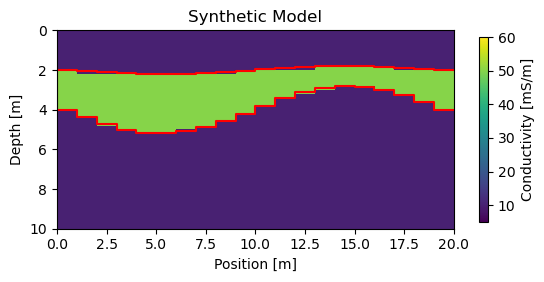

In [7]:
#Plot synthetic model

depth, sigy = PlotModel(thk1, thk2, sigmas, npos, ny, 'Synthetic Model')

plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])),'r')

In [8]:
# Create synthetic data

# Create empty array for true data in each position
data = []

for i in range(npos):
    model_i = np.hstack((sigmas[i], thk1[i], thk2[i])) # True model 
    
    data.append(Analytic_Forward(sigmas[i][0], sigmas[i][1], sigmas[i][2], thk1[i], thk2[i])) # creating data



In [9]:
# Calculate normalization by coil and OP /IP

data = np.array(data)

# data shape is (npos, geometries * 2) 

Q_HCP_2 = data[:,0]
Q_HCP_4 = data[:,1]
Q_HCP_8 = data[:,2]
Q_VCP_2 = data[:,3]
Q_VCP_4 = data[:,4]
Q_VCP_8 = data[:,5]
Q_PRP_2 = data[:,6]
Q_PRP_4 = data[:,7]
Q_PRP_8 = data[:,8]

P_HCP_2 = data[:,9]
P_HCP_4 = data[:,10]
P_HCP_8 = data[:,11]
P_VCP_2 = data[:,12]
P_VCP_4 = data[:,13]
P_VCP_8 = data[:,14]
P_PRP_2 = data[:,15]
P_PRP_4 = data[:,16]
P_PRP_8 = data[:,17]

# Calculate L2 norm

L2_Q_HCP_2 = np.sqrt(np.sum(Q_HCP_2**2))
L2_Q_HCP_4 = np.sqrt(np.sum(Q_HCP_4**2))
L2_Q_HCP_8 = np.sqrt(np.sum(Q_HCP_8**2))

L2_Q_VCP_2 = np.sqrt(np.sum(Q_VCP_2**2))
L2_Q_VCP_4 = np.sqrt(np.sum(Q_VCP_4**2))
L2_Q_VCP_8 = np.sqrt(np.sum(Q_VCP_8**2))

L2_Q_PRP_2 = np.sqrt(np.sum(Q_PRP_2**2))
L2_Q_PRP_4 = np.sqrt(np.sum(Q_PRP_4**2))
L2_Q_PRP_8 = np.sqrt(np.sum(Q_PRP_8**2))

L2_P_HCP_2 = np.sqrt(np.sum(P_HCP_2**2))
L2_P_HCP_4 = np.sqrt(np.sum(P_HCP_4**2))
L2_P_HCP_8 = np.sqrt(np.sum(P_HCP_8**2))

L2_P_VCP_2 = np.sqrt(np.sum(P_VCP_2**2))
L2_P_VCP_4 = np.sqrt(np.sum(P_VCP_4**2))
L2_P_VCP_8 = np.sqrt(np.sum(P_VCP_8**2))

L2_P_PRP_2 = np.sqrt(np.sum(P_PRP_2**2))
L2_P_PRP_4 = np.sqrt(np.sum(P_PRP_4**2))
L2_P_PRP_8 = np.sqrt(np.sum(P_PRP_8**2))

L2_Q_HCP = np.hstack((L2_Q_HCP_2, L2_Q_HCP_4, L2_Q_HCP_8))
L2_Q_VCP = np.hstack((L2_Q_VCP_2, L2_Q_VCP_4, L2_Q_VCP_8))
L2_Q_PRP = np.hstack((L2_Q_PRP_2, L2_Q_PRP_4, L2_Q_PRP_8))

L2_P_HCP = np.hstack((L2_P_HCP_2, L2_P_HCP_4, L2_P_HCP_8))
L2_P_VCP = np.hstack((L2_P_VCP_2, L2_P_VCP_4, L2_P_VCP_8))
L2_P_PRP = np.hstack((L2_P_PRP_2, L2_P_PRP_4, L2_P_PRP_8))

L2 = np.stack((L2_Q_HCP, L2_Q_VCP, L2_Q_PRP, L2_P_HCP, L2_P_VCP, L2_P_PRP))

In [10]:
def Analytic_Forward_norm(sigma1, sigma2, sigma3, thick1, thick2, height=height):
    # Returns apparent conductivity for each coil geometry and separation
    
    sigma1 = sigma1/1000
    sigma2 = sigma2/1000
    sigma3 = sigma3/1000
    
    surface = 0
    depth = [surface, thick1, thick1 + thick2]
    res_air = 2e14
    res = [res_air, 1/sigma1, 1/sigma2, 1/sigma3]
    HCP_Hs = empymod.loop(Hsource, Hreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    VCP_Hs = empymod.loop(Vsource, Vreceivers, depth, res, freq, xdirect=None, mrec = 'loop', verb=0)
    PRP_Hs = empymod.dipole(Psource, Preceivers, depth, res, freq, ab = 64, xdirect = None, verb = 0)

    HCP_Hp = empymod.loop(Hsource, Hreceivers, depth=[], res=[res_air], freqtime=freq, mrec = 'loop', verb=0)
    VCP_Hp = empymod.loop(Vsource, Vreceivers, depth=[], res=[res_air], freqtime=freq, mrec = 'loop', verb=0)
    PRP_Hp = empymod.dipole(Psource, Preceivers, depth=[], res=[res_air], freqtime = freq, ab = 66, verb = 0)
   
    Q_HCP = -np.imag(HCP_Hs/HCP_Hp)/L2[0]
    Q_VCP = np.imag(VCP_Hs/VCP_Hp)/L2[1]
    Q_PRP = np.imag(PRP_Hs/PRP_Hp)/L2[2]

    P_HCP = -np.real(HCP_Hs/HCP_Hp)/L2[3]
    P_VCP = np.real(VCP_Hs/VCP_Hp)/L2[4]
    P_PRP = np.real(PRP_Hs/PRP_Hp)/L2[5]
    
    return np.hstack((Q_HCP, Q_VCP, Q_PRP, P_HCP, P_VCP, P_PRP))

In [11]:
model=[]
data_norm=[]

for i in range(npos):
    model_i = np.hstack((sigmas[i], thk1[i], thk2[i])) # True model 
    model.append(model_i)
    data_norm.append(Analytic_Forward_norm(sigmas[i][0], sigmas[i][1], sigmas[i][2], thk1[i], thk2[i])) # creating data

# Relative error array
error = 1e-3 # introduce here the error you want to test
relativeError = np.ones_like(data_norm[0]) * error

In [12]:
class Analytic(pg.Modelling):
    
    def __init__(self):
        """Initialize the model."""
        super().__init__()
        
    def response(self, x):
        
        sigma1 = x[0]
        sigma2 = x[1]
        sigma3 = x[2]
        thick1 = x[3]
        thick2 = x[4]
        
        Z = Analytic_Forward_norm(sigma1, sigma2, sigma3, thick1, thick2)

        return Z
        
    def createStartModel(self, dataVals):
        
        thk_ini = [2, 2]
        sig_ini = [10, 10, 10]
        x0 = sig_ini + thk_ini
        return np.array(x0)

In [13]:
# Define inversion transformations

transData = pg.trans.TransLin() # log transformation for data
transModel = pg.trans.TransLog() # log-transform ensures thk>0

ANAf = Analytic()
inv_Ana = pg.Inversion()
inv_Ana.setForwardOperator(ANAf)

inv_Ana.transModel = transModel
inv_Ana.transData = transData

In [14]:
# Start inversion

model_est_list =[] # empty array to store the model estimated

for i in range(npos):
    
    dataE = data_norm[i].copy()
    dataE *= np.random.randn(len(dataE)) * relativeError + 1.0

    model_est = inv_Ana.run(dataE, relativeError, verbose=False, lam=100, maxIter=40)
    
    model_est_list.append(model_est)

# Model estimation array    
model_est_arr_ANA = np.array(model_est_list)

01/12/22 - 14:19:46 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 14:19:47 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 14:19:48 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 14:19:50 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 14:19:51 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 14:19:52 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 14:19:53 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 14:19:54 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 14:19:55 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 14:19:56 - pyGIMLi - INFO - Created startmodel from forward operator: [10 10 10  2  2]
01/12/22 - 14:19:58 

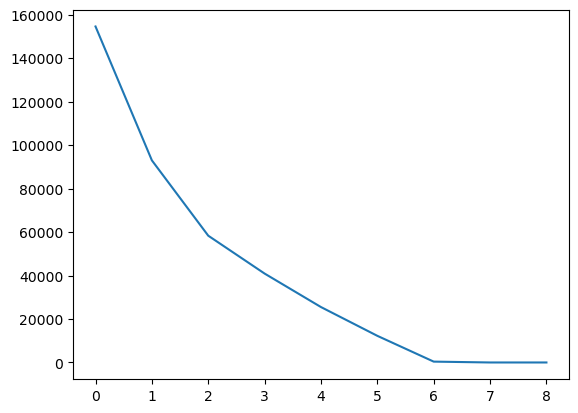

In [15]:
# Need to save chi2 history per position
plt.plot(inv_Ana.chi2History)

In [16]:
# Need to save per position inv_Ana.modelHistory

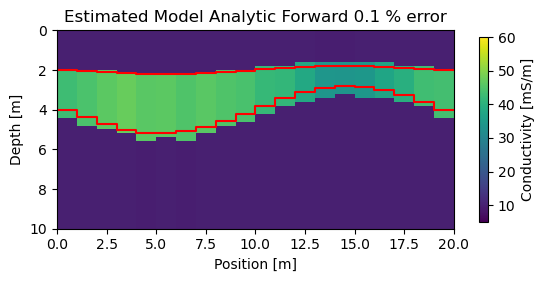

In [17]:
# Plot estimated model with LIN Approx

depth_,sigyANA = PlotModel(model_est_arr_ANA[:,3], model_est_arr_ANA[:,4], model_est_arr_ANA[:,:3] , npos, ny,
                                 'Estimated Model Analytic Forward ' + str(error*100) + ' % error')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,1],depth[-1,1])), 'r')
plt.step(np.hstack((xx, xx[-1])), np.hstack((depth[0,1],depth[:,2],depth[-1,2])), 'r')

In [18]:
# Plot Real data versus estimated model data

# Create empty array for true data in each position
data_ANA_est = []

data_HCP2m_Q=[]
data_HCP4m_Q=[]
data_HCP8m_Q=[]
data_VCP2m_Q=[]
data_VCP4m_Q=[]
data_VCP8m_Q=[]
data_PRP2m_Q=[]
data_PRP4m_Q=[]
data_PRP8m_Q=[]

data_HCP2m_P=[]
data_HCP4m_P=[]
data_HCP8m_P=[]
data_VCP2m_P=[]
data_VCP4m_P=[]
data_VCP8m_P=[]
data_PRP2m_P=[]
data_PRP4m_P=[]
data_PRP8m_P=[]

data_HCP2m_Q_est=[]
data_HCP4m_Q_est=[]
data_HCP8m_Q_est=[]
data_VCP2m_Q_est=[]
data_VCP4m_Q_est=[]
data_VCP8m_Q_est=[]
data_PRP2m_Q_est=[]
data_PRP4m_Q_est=[]
data_PRP8m_Q_est=[]

data_HCP2m_P_est=[]
data_HCP4m_P_est=[]
data_HCP8m_P_est=[]
data_VCP2m_P_est=[]
data_VCP4m_P_est=[]
data_VCP8m_P_est=[]
data_PRP2m_P_est=[]
data_PRP4m_P_est=[]
data_PRP8m_P_est=[]

for i in range(npos):
    model_i = model_est_arr_ANA[i] # True model 
    data_ANA_est.append(ANAf(model_i)) # creating data
    
    data_HCP2m_Q.append(data_norm[i][0])
    data_HCP4m_Q.append(data_norm[i][1])
    data_HCP8m_Q.append(data_norm[i][2])
    data_VCP2m_Q.append(data_norm[i][3])
    data_VCP4m_Q.append(data_norm[i][4])
    data_VCP8m_Q.append(data_norm[i][5])
    data_PRP2m_Q.append(data_norm[i][6])
    data_PRP4m_Q.append(data_norm[i][7])
    data_PRP8m_Q.append(data_norm[i][8])
    data_HCP2m_P.append(data_norm[i][9])
    data_HCP4m_P.append(data_norm[i][10])
    data_HCP8m_P.append(data_norm[i][11])
    data_VCP2m_P.append(data_norm[i][12])
    data_VCP4m_P.append(data_norm[i][13])
    data_VCP8m_P.append(data_norm[i][14])
    data_PRP2m_P.append(data_norm[i][15])
    data_PRP4m_P.append(data_norm[i][16])
    data_PRP8m_P.append(data_norm[i][17])
    
    data_HCP2m_Q_est.append(data_ANA_est[i][0])
    data_HCP4m_Q_est.append(data_ANA_est[i][1])
    data_HCP8m_Q_est.append(data_ANA_est[i][2])
    data_VCP2m_Q_est.append(data_ANA_est[i][3])
    data_VCP4m_Q_est.append(data_ANA_est[i][4])
    data_VCP8m_Q_est.append(data_ANA_est[i][5])
    data_PRP2m_Q_est.append(data_ANA_est[i][6])
    data_PRP4m_Q_est.append(data_ANA_est[i][7])
    data_PRP8m_Q_est.append(data_ANA_est[i][8])
    data_HCP2m_P_est.append(data_ANA_est[i][9])
    data_HCP4m_P_est.append(data_ANA_est[i][10])
    data_HCP8m_P_est.append(data_ANA_est[i][11])
    data_VCP2m_P_est.append(data_ANA_est[i][12])
    data_VCP4m_P_est.append(data_ANA_est[i][13])
    data_VCP8m_P_est.append(data_ANA_est[i][14])
    data_PRP2m_P_est.append(data_ANA_est[i][15])
    data_PRP4m_P_est.append(data_ANA_est[i][16])
    data_PRP8m_P_est.append(data_ANA_est[i][17])



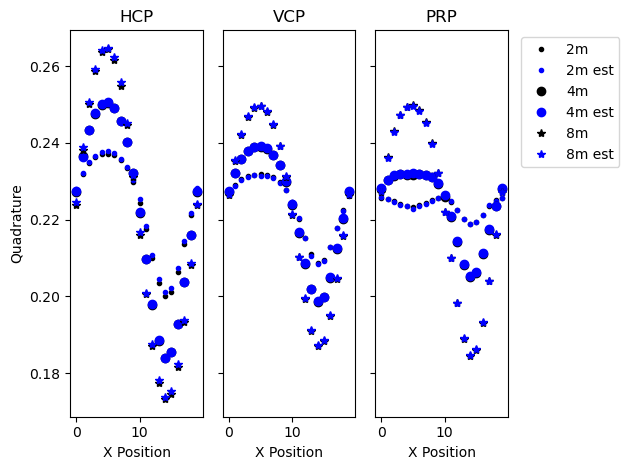

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True)

ax1.plot(data_HCP2m_Q, '.k' , label = '2m')
ax1.plot(data_HCP2m_Q_est, '.b', label = '2m est')
ax1.plot(data_HCP4m_Q, 'ok' , label = '4m')
ax1.plot(data_HCP4m_Q_est, 'ob', label = '4m est')
ax1.plot(data_HCP8m_Q, '*k' , label = '8m')
ax1.plot(data_HCP8m_Q_est, '*b', label = '8m est')
ax1.set_xlabel('X Position')
ax1.set_ylabel('Quadrature')
ax1.set_title('HCP')
#ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

ax2.plot(data_VCP2m_Q, '.k' , label = '2m')
ax2.plot(data_VCP2m_Q_est, '.b', label = '2m est')
ax2.plot(data_VCP4m_Q, 'ok' , label = '4m')
ax2.plot(data_VCP4m_Q_est, 'ob', label = '4m est')
ax2.plot(data_VCP8m_Q, '*k' , label = '8m')
ax2.plot(data_VCP8m_Q_est, '*b', label = '8m est')
ax2.set_xlabel('X Position')
#ax2.set_ylabel('Quadrature')
ax2.set_title('VCP')

ax3.plot(data_PRP2m_Q, '.k' , label = '2m')
ax3.plot(data_PRP2m_Q_est, '.b', label = '2m est')
ax3.plot(data_PRP4m_Q, 'ok' , label = '4m')
ax3.plot(data_PRP4m_Q_est, 'ob', label = '4m est')
ax3.plot(data_PRP8m_Q, '*k' , label = '8m')
ax3.plot(data_PRP8m_Q_est, '*b', label = '8m est')
ax3.set_xlabel('X Position')
#ax3.set_ylabel('Quadrature')
ax3.set_title('PRP')
ax3.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.tight_layout()


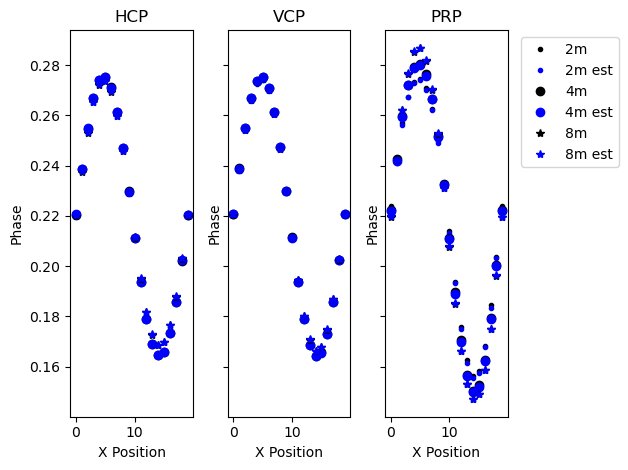

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True)

ax1.plot(data_HCP2m_P, '.k' , label = '2m')
ax1.plot(data_HCP2m_P_est, '.b', label = '2m est')
ax1.plot(data_HCP4m_P, 'ok' , label = '4m')
ax1.plot(data_HCP4m_P_est, 'ob', label = '4m est')
ax1.plot(data_HCP8m_P, '*k' , label = '8m')
ax1.plot(data_HCP8m_P_est, '*b', label = '8m est')
ax1.set_xlabel('X Position')
ax1.set_ylabel('Phase')
ax1.set_title('HCP')

ax2.plot(data_VCP2m_P, '.k' , label = '2m')
ax2.plot(data_VCP2m_P_est, '.b', label = '2m est')
ax2.plot(data_VCP4m_P, 'ok' , label = '4m')
ax2.plot(data_VCP4m_P_est, 'ob', label = '4m est')
ax2.plot(data_VCP8m_P, '*k' , label = '8m')
ax2.plot(data_VCP8m_P_est, '*b', label = '8m est')
ax2.set_xlabel('X Position')
ax2.set_ylabel('Phase')
ax2.set_title('VCP')

ax3.plot(data_PRP2m_P, '.k' , label = '2m')
ax3.plot(data_PRP2m_P_est, '.b', label = '2m est')
ax3.plot(data_PRP4m_P, 'ok' , label = '4m')
ax3.plot(data_PRP4m_P_est, 'ob', label = '4m est')
ax3.plot(data_PRP8m_P, '*k' , label = '8m')
ax3.plot(data_PRP8m_P_est, '*b', label = '8m est')
ax3.set_xlabel('X Position')
ax3.set_ylabel('Phase')
ax3.set_title('PRP')
ax3.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.tight_layout()